In [1]:
from PIL import Image, ImageDraw
import clip 
import json 
import numpy as np 
import torch 
from torchvision.ops import nms
from torch.utils.data import Dataset, DataLoader, SequentialSampler
import cv2 
from itertools import chain, combinations
import pandas as pd 
import torch.nn.functional as F
import random
from tqdm import tqdm 
import sys 
sys.path.append('..')
sys.path.append('.')
from src.config import config 
from torchvision import transforms

ImportError: cannot import name 'config' from 'src.config' (/home/saaket/embodiedAI/lsd/notebooks/../src/config.py)

In [4]:
config.train_split = config.raw_data_path + '/way_spits/train_data.json'
config.valSeen_split = config.raw_data_path + '/way_spits/valSeen_data.json'
config.valUnseen_split = config.raw_data_path + '/way_spits/valUnseen_data.json'
config.bbox_colors = ['red', 'blue, green']
config.tokenizer = clip.tokenize
config.max_floors = 5
config.mesh2meters_file = '../data/raw/floorplans/pix2meshDistance.json'
config.ds_percent = 0.65
config.colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 100, 100)]
config.floorplans_dir = '../data/raw/floorplans'

In [4]:
processed_data = torch.load('/home/saaket/embodiedAI/lsd/data/processed/conventional/best_bbox_arr_train_one_utterance_all_floors.pt')

In [10]:
processed_data[0]['floors']

{1: [(0,
   'Look for a white couch next to a rug with square patterns that are blue black and white.',
   array([495, 351, 557, 426], dtype=int32))],
 0: [(1,
   'Put me in the middle of the rug.',
   array([538, 286, 658, 411], dtype=int32))]}

In [6]:
painted_images = []

In [30]:
class LSDDataset(Dataset):
    def __init__(self, processed_data, config):
        self.data = processed_data
        self.config = config
        self.tokenizer = config.tokenizer
        self.mesh2meters = json.load(open(config.mesh2meters_file))
        self.mode = 'train'
        self.painted_images = []
        self.image_size = [
            3,
            int(700 * self.config.ds_percent),
            int(1200 * self.config.ds_percent),
        ]
        self.preprocess_data_aug = transforms.Compose(
            [
                transforms.ColorJitter(brightness=0.5, hue=0.1, saturation=0.1),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.48145466, 0.4578275, 0.40821073, 0.555], # [0.485, 0.456, 0.406, 0.555],
                    std= [0.26862954, 0.26130258, 0.27577711, 0.222]# [0.229, 0.224, 0.225, 0.222],
                ),
            ]
        )
        self.preprocess = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.48145466, 0.4578275, 0.40821073, 0.555], # [0.485, 0.456, 0.406, 0.555],
                    std= [0.26862954, 0.26130258, 0.27577711, 0.222]# [0.229, 0.224, 0.225, 0.222],
                ),
            ]
        )
    def __len__(self):
        return len(self.data)
    
    def gather_all_floors(self, idx):
        all_maps = torch.zeros(
            self.config.max_floors,
            self.image_size[0],
            self.image_size[1],
            self.image_size[2],
        )
        all_conversions = torch.zeros(self.config.max_floors, 1)
        sn = self.data[idx]['scanName']
        floors = self.mesh2meters[sn].keys()
        bboxes_on_floors = self.data[idx]['floors']
        bboxes = self.data[idx]['bboxes']
        bbox_colors = self.config.colors[:len(bboxes)]

        for enum, f in enumerate(floors):
            img = Image.open(
                "{}/floor_{}/{}_{}.png".format(self.config.floorplans_dir, f, sn, f)
            ).convert('RGBA')
            if int(f) in bboxes_on_floors:
                for bb in bboxes_on_floors[int(f)]:
                    bbox_idx, _, bbox_coords = bb
                    img = self.paint_bbox(img, bbox_coords, bbox_colors[bbox_idx]) 
                    self.painted_images.append(img)


            img = img.resize((self.image_size[2], self.image_size[1]))
            if "train" in self.mode:
                all_maps[enum, :, :, :] = self.preprocess_data_aug(img)[:3, :, :]
            else:
                all_maps[enum, :, :, :] = self.preprocess(img)[:3, :, :]
            all_conversions[enum, :] = self.mesh2meters[sn][f]["threeMeterRadius"] / 3.0

        return all_maps, all_conversions
    
    def paint_bbox(self, image, bbox, color):
        x1, y1, x2, y2 = bbox
        overlay = Image.new('RGBA', image.size, color+(0,))
        draw = ImageDraw.Draw(overlay)  # Create a context for drawing things on it.
        draw.rectangle((x1, y1, x2, y2), fill=color+(50,))

        # Alpha composite these two images together to obtain the desired result.
        image = Image.alpha_composite(image, overlay)
        return image 
    
    def __getitem__(self, idx):
        maps, conversions = self.gather_all_floors(idx)
    
        return {
            'maps': maps, 
            'conversions': conversions,
            'paints': self.painted_images
        }
        

        
        

In [31]:
train_dataset = LSDDataset(processed_data, config)

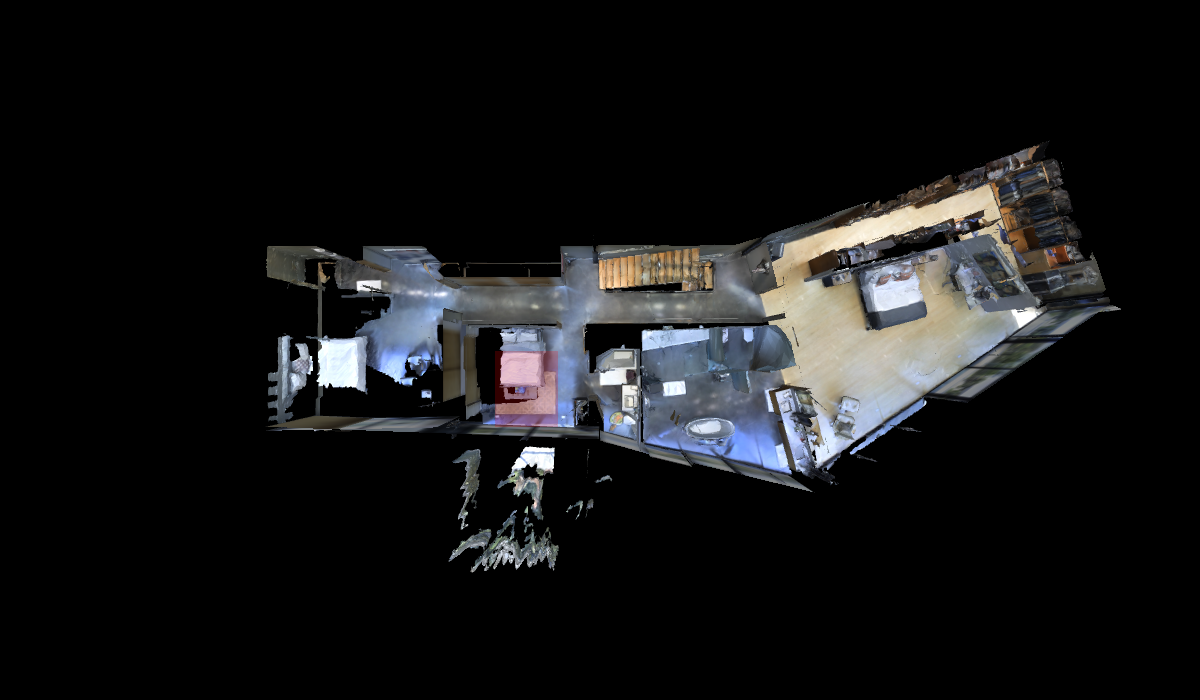

In [34]:
train_dataset[0]['paints'][1]

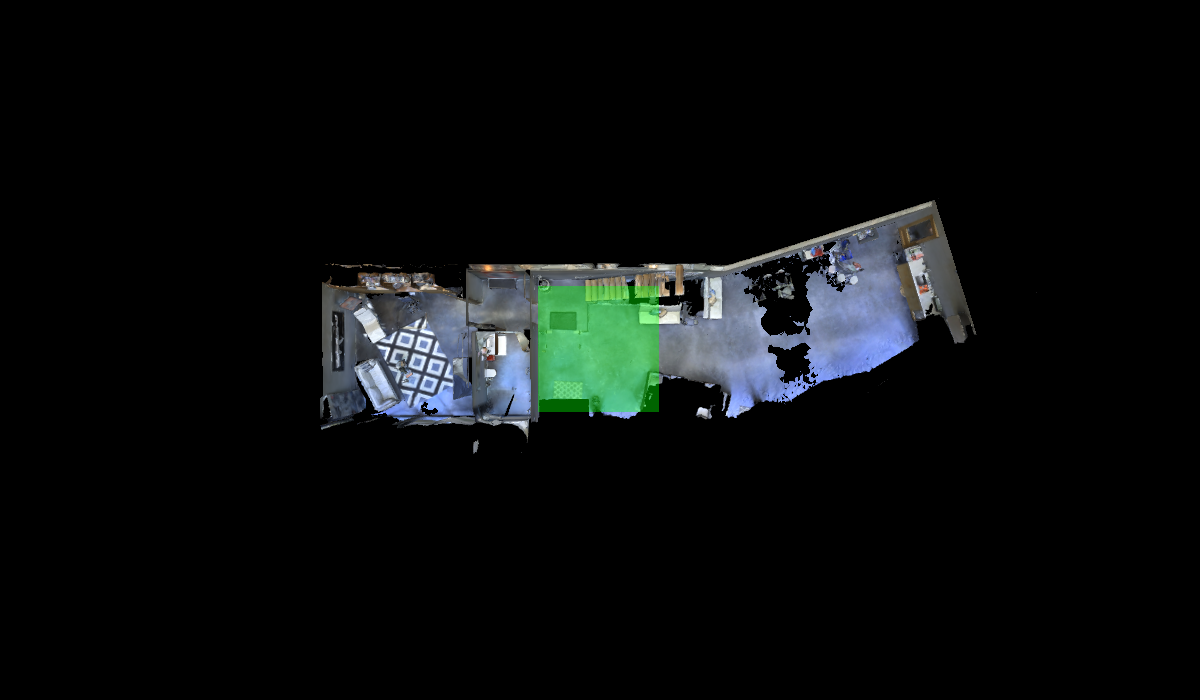

In [18]:
painted_images[0]

In [ ]:
# dialog_array = self.data[idx]['processed_dialog_array']
#         episode_id = self.data[idx]['episode_id']
#         scan_name = self.data[idx]['scan_name']
#         bboxes = self.data[idx]['bboxes']
#         final_pixel_location = self.data[idx]['finalLocation']['pixel_coord']
#         final_viewpoint = self.data[idx]['finalLocation']['viewPoint']
#         self.floor = self.data[idx]['finalLocation']['floor']